# ML T-Generation Занятие 3: Линейная регрессия.
# Проблема переобучения. Кросс-валидация и регуляризация.

Авторы: Гаркавый Андрей (andrewgarkavyy@gmail.com), Кирилл Васильев (kirivasile@yandex.ru)

Переработал: Чайников Константин (chainikov.k.m@gmail.com)

## 0. План

1. Линейная регрессия

2. Приближение многочленом

3. Переобучение

4. Выводы

5. Разделение на тренировочную и тестовую части

6. Кросс-валидация

7. Как подбираются коэффициенты

8. Регуляризация



## 1. Линейная регрессия
**Регрессией** называется задача машинного обучения с учителем, в которой у нас есть много объектов с признаками, у которых надо научиться приближенно предсказывать значение целевой функции, которая равна какому-то **действительному числу**. 

В этом будет отличие задачи регрессии от задачи классификации - регрессия предсказывает число, а классификация - один из нескольких классов.**Текст, выделенный полужирным шрифтом**

In [3]:
from sklearn.linear_model import LinearRegression
import numpy as np
import warnings
import pandas as pd
# %matplotlib inline
from matplotlib import pyplot as plt
warnings.filterwarnings("ignore")

In [ ]:
model = LinearRegression(fit_intercept=True  )

Давайте положим в X какие-то трехмерные векторы.

In [ ]:
X = np.ones((200,3))

X[:,1]*=np.random.normal(0,1,(200,))
X[:,2]*=np.random.normal(0,1,(200,))
X

array([[ 1.00000000e+00, -4.31323959e-01,  1.52461956e+00],
       [ 1.00000000e+00, -2.40353755e-01, -1.11619351e+00],
       [ 1.00000000e+00,  3.72777666e-01, -1.00761735e-01],
       [ 1.00000000e+00, -1.70083321e+00, -2.48364186e-01],
       [ 1.00000000e+00,  3.54885105e-01, -6.52951998e-01],
       [ 1.00000000e+00, -8.44109093e-01, -1.08385619e+00],
       [ 1.00000000e+00,  2.99339586e-01, -4.64042163e-01],
       [ 1.00000000e+00,  2.98906091e+00,  5.28264891e-01],
       [ 1.00000000e+00, -7.84502753e-02,  3.18557602e-02],
       [ 1.00000000e+00, -1.52354400e+00, -9.35257069e-02],
       [ 1.00000000e+00, -1.34819016e+00,  8.04147101e-01],
       [ 1.00000000e+00,  8.28477325e-01,  1.90641705e+00],
       [ 1.00000000e+00, -1.00505272e+00,  1.31158271e-01],
       [ 1.00000000e+00, -8.86458303e-01, -2.93094159e-01],
       [ 1.00000000e+00,  5.50884872e-01, -5.39404651e-01],
       [ 1.00000000e+00, -1.01914283e-01, -2.38839558e-01],
       [ 1.00000000e+00,  6.64711919e-01

Построим $y$ по такой формуле:

$$y = 50 + 14x_1 - 7x_2  + \varepsilon$$

Где $\varepsilon$ - это какой-то шум с нормальным распределением с дисперсией 5, чтобы линейная формула не была уж совсем точной.

In [ ]:
y = X @ np.array([50,14,-7]) + np.random.normal(0,5,(200,))
y

array([34.78634684, 59.93600521, 51.39811331, 26.76355847, 63.41224077,
       40.31815224, 58.83483632, 82.73719361, 54.7169597 , 33.04902624,
       26.23532897, 50.12263348, 35.54995118, 44.32733047, 54.74840987,
       48.13438937, 63.7949892 , 75.42142695, 45.80287448, 53.32087491,
       42.01665567, 53.9206108 , 32.63587987, 41.38547514, 31.62718429,
       39.72061654, 27.92644511, 73.79819882, 27.60521141, 61.90024998,
       40.46348021, 41.75084433, 29.2879875 , 52.70793335, 70.01472596,
       56.97699063, 21.0847672 , 55.0089368 , 45.38259731, 56.21025926,
       61.54832358, 27.80276706, 45.19182668,  8.34705817, 71.08517376,
       44.14589784, 77.53116942, 42.9511439 , 45.5579585 , 53.45034696,
       45.14939689, 34.72505723, 63.40595003, 43.85151851, 52.60725183,
       21.25130712, 57.31625623, 40.03194192, 57.81089637, 22.94001708,
       60.14354233, 79.85143457, 41.62358315, 54.17560078, 74.4216597 ,
       35.36366885, 59.99504847, 44.20578396, 67.36494303, 43.91

Теперь обучим на этих данных линейную регрессию и посмотрим, сможет ли она восстановить параметры модели $50, 14, -7$.

In [ ]:
model.fit(X[:,[1,2]], y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
coefs = model.coef_
coefs

array([14.33649811, -7.11195197])

In [ ]:
const = model.intercept_
const

50.11674603814367

In [ ]:
np.linalg.inv(X.T @ X) @ X.T @ y 

array([50.11674604, 14.33649811, -7.11195197])

In [ ]:
# X = np.ones((200,3))
# X[:,1]*=np.random.normal(0,1,(200,))
# X[:,2]*=np.random.normal(0,1,(200,))

# y = X @ np.array([50,14,-7]) + np.random.normal(0,5,(200,))

In [4]:
import plotly.express as px
import plotly.graph_objects as go


fig = px.scatter_3d(np.concatenate((X,y.reshape(-1,1)), axis=1),  x=1, y=2, z=3,
                    size_max=5, opacity=0.5, color_discrete_sequence=['red'])

# tight layout
fig.update_layout(margin=dict(l=10, r=100, b=100, t=10))

x1 = np.linspace(-3, 3, 30)
y1 = np.linspace(-3, 3, 30)
xx, yy = np.meshgrid(x1, y1)
z = np.c_[xx.ravel(), yy.ravel()] @ np.array(coefs[0:2]) + const 

# transpose
z = z.reshape(xx.shape)
fig.add_traces(go.Surface(x=x1, y=y1, z=z, showscale=False,
                          opacity=0.3, colorscale=[[0, 'rgb(0,0,255)'], [1, 'rgb(0,0,255)']]))
fig.show()

NameError: name 'X' is not defined

И внезапно линейная регрессия как-то примерно угадала наши коэффициенты! Примерно, потому что мы добавили шум.

Как она это делает? Сейчас узнаем.

### КАК работает линейная регрессия

По сути мы хотим подобрать числа $a_0, a_1, a_2, a_3$ для вот такой модели:

$$f(x_1, x_2, x_3) = a_0 + a_1 x_1 + a_2 x_2 + a_3 x_3$$

Мы хотим подобрать их так, чтобы функция потерь на наших данных была минимальна. В LinearRegression используют функцию потерь MSE - сумму квадратов отклонений от настоящего значения.

То есть задача такая:

$$\sum\limits_{i=1}^{n}(f(x_{i1}, x_{i2}, x_{i3}) - y_i)^2 \rightarrow \min$$


$$\sum\limits_{i=1}^{n}(a_0 + a_1 x_{i1} + a_2 x_{i2} + a_3 x_{i3} - y_i)^2 \rightarrow \min$$

Где n - это количество входных данных. Давайте рассмотрим эту сумму как функцию от 4 переменных $a_0, a_1, a_2, a_3$, которую нам нужно минимизировать. А числа $x_{ij}$ и $y_i$, получается, будут обычными константами.

$$MSE(a_0, a_1, a_2, a_3) \rightarrow \min$$

Давайте посчитаем частную производную по каждой координате.

Начнем с координаты $a_1$.

$$MSE'_{a_1}(a_0, a_1, a_2, a_3) = \sum\limits_{i=1}^{n}((a_0 + a_1 x_{i1} + a_2 x_{i2} + a_3 x_{i3} - y_i)^2)'_{a_1}=$$

Раскрываем квадрат, вынося отдельно члены, которые делятся на $a_1^2$, $a_1$ и $1$.

$$= \sum\limits_{i=1}^{n}(x_{i1}^2a_1^2 + 2x_{i1}(a_0 + a_2 x_{i2} + a_3 x_{i3} - y_i)a_1 + (a_0 + a_2 x_{i2} + a_3 x_{i3} - y_i)^2)'_{a_1}=$$

Считаем производную, одна из скобок при этом обнуляется:

$$= \sum\limits_{i=1}^{n}(2x_{i1}^2a_1 + 2x_{i1}(a_0 + a_2 x_{i2} + a_3 x_{i3} - y_i))=$$

Теперь вынесем $2$ и $x_{i1}$

$$= 2\sum\limits_{i=1}^{n}(x_{i1}a_1 + a_0 + a_2 x_{i2} + a_3 x_{i3} - y_i)x_{i1}=$$

Заметим, что в скобках получилось очень простое выражение!

$$= 2\sum\limits_{i=1}^{n}(f(x_{i1}, x_{i2}, x_{i3}) - y_i)x_{i1}$$

Давайте приравняем все 4 производные (по $a_0, a_1, a_2, a_3$) нулю, тогда:

$$\sum\limits_{i=1}^{n}(a_0 + a_1 x_{i1} + a_2 x_{i2} + a_3 x_{i3} - y_i) = 0$$
$$\sum\limits_{i=1}^{n}(a_0 + a_1 x_{i1} + a_2 x_{i2} + a_3 x_{i3} - y_i)x_{i1} = 0$$
$$\sum\limits_{i=1}^{n}(a_0 + a_1 x_{i1} + a_2 x_{i2} + a_3 x_{i3} - y_i)x_{i2} = 0$$
$$\sum\limits_{i=1}^{n}(a_0 + a_1 x_{i1} + a_2 x_{i2} + a_3 x_{i3} - y_i)x_{i3} = 0$$

Давайте сгруппируем все выражения по $a_0, a_1, a_2, a_3$:

$$na_0 + (\sum\limits_{i=1}^{n}x_{i1})a_1 + (\sum\limits_{i=1}^{n}x_{i2})a_2 + (\sum\limits_{i=1}^{n}x_{i3})a_3= \sum\limits_{i=1}^{n}y_i$$

$$(\sum\limits_{i=1}^{n}x_{i1})a_0 + (\sum\limits_{i=1}^{n}x_{i1}^2)a_1 + (\sum\limits_{i=1}^{n}x_{i1}x_{i2})a_2 + (\sum\limits_{i=1}^{n}x_{i1}x_{i3})a_3= \sum\limits_{i=1}^{n}x_{i1}y_i$$

$$(\sum\limits_{i=1}^{n}x_{i2})a_0 + (\sum\limits_{i=1}^{n}x_{i1}x_{i2})a_1 + (\sum\limits_{i=1}^{n}x_{i2}^2)a_2 + (\sum\limits_{i=1}^{n}x_{i2}x_{i3})a_3= \sum\limits_{i=1}^{n}x_{i2}y_i$$

$$(\sum\limits_{i=1}^{n}x_{i3})a_0 + (\sum\limits_{i=1}^{n}x_{i1}x_{i3})a_1 + (\sum\limits_{i=1}^{n}x_{i2}x_{i3})a_2 + (\sum\limits_{i=1}^{n}x_{i3}^2)a_3= \sum\limits_{i=1}^{n}x_{i3}y_i$$

Ура, мы получили красивую симметричную систему уравнения, 4 уравнения, 4 неизвестных. Если определитель матрицы коэффициентов не равен нулю, то у него есть ровно одно решение, и его мы умеем находить (методом Гаусса, например). Если определитель вдруг стал равен нулю, то решений либо 0, либо бесконечно.

У непрерывно-дифференцируемой функции, которая при стремлении по каждой координате к плюс или минус бесконечности сама стремится к плюс бесконечности, всегда существует глобальный минимум. В точке глобального минимума все производные как раз равны нулю. Следовательно, существует всегда хотя бы одно решение, и мы его найдем.

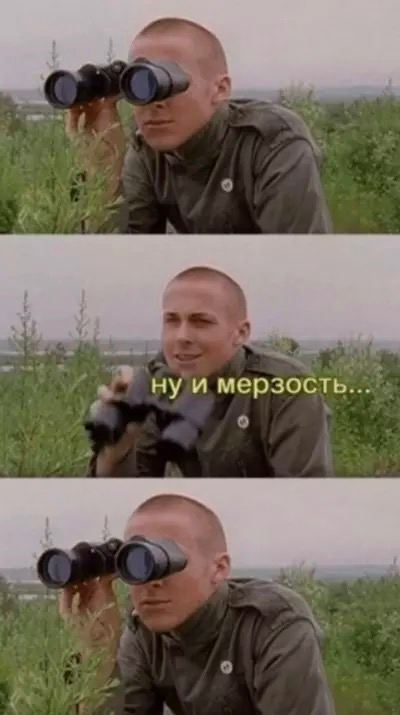

## 2. Приближение одномерной функции многочленом

Начнем с простой задачи.


1) Есть функция $f(x)$, но мы ее не знаем.

2) Зато мы знаем ее значения в $m$ точках (они называются тренировочным множеством):
$$f(x_1) = y_1$$
$$\cdots$$
$$f(x_m) = y_m$$
3) Нужно научиться приблизительно восстанавливать эту функцию.

Самый простой способ - научиться приближать её многочленом, а именно давайте подберем такие коэффициенты $a_0, a_1, \ldots, a_n$, чтобы многочлен $P(x) = a_0 + a_1x + a_2x^2 + \ldots + a_nx^n$ был как можно ближе к $f(x)$.

Но что такое "приблизить"? Мы знаем лишь значения в $m$ точках, так что в лучшем случае она должна проходить через все эти точки (хотя скоро мы увидим, что это не так).

В этом случае обычно пытаются минимизировать сумму квадратов ошибок во всех точках, то есть **функцию потерь** $$Q(P) = \sum_i (P(x_i) - f(x_i))^2 $$

Эту величину называют **MSE** - Mean Squared Error (средняя квадратичная ошибка).

Тут может возникнуть вопрос, почему мы берем именно сумму квадратов, а не, например, сумму модулей. Однозначного ответа на этот вопрос нет, наиболее удачный ответ, пожалуй такой: у суммы квадратов есть много удобных свойств, например это выпуклая, дифференцируемая функция. Тем не менее иногда другой выбор может быть оправданным. Если вам интересно чуть больше понять про смысл этих условий, можете решить такие задачи:

**(0.5 балла) Доп. Задача 1.** Найдите число m такое, что для заданных $x_i$ сумма $\sum|m - x_i|$ минимальна

<Место для решения>

**(0.5 балла) Доп. Задача 2.** Найдите число m такое, что для заданных $x_i$ сумма $\sum(m - x_i)^2$ минимальна


<место для решения>

Сейчас можно их и пропустить.


Сначала просто нарисуем какой-нибудь многочлен, например $f(x) = 3x^3 - 2x^2 + x$ на отрезке $[-1, 1]$:

In [73]:
def f(x):
    return 3 * x ** 3 - 2 * x**2 + x

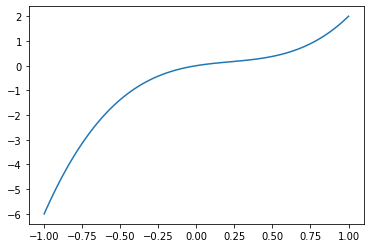

In [7]:
x100 = np.linspace(-1, 1, 100)
plt.plot(x100, f(x100))
plt.show()

Теперь зададим набор точек (10 штук) и посмотрим что будет, если подобрать по ним коэффициенты нашего многочлена:

In [74]:
x = np.linspace(-1, 1, 10)  # 10 точек на отрезке [-1, 1]
y = f(x)
coefs = np.polyfit(x, y, deg = 2)
coefs

array([-2.00000000e+00,  3.17037037e+00, -3.93270787e-16])

(это означает многочлен $-2x^2 + 3.17037 x$)

numpy позволяет легко работать с многочленами, заданными их коэффициентами. Мы можем создать из них объект poly1d, который можно будет просто вызывать для получения нужных значений:

In [6]:
poly = np.poly1d(coefs)
poly(0), poly(1), poly(2)

(-3.93270786911128e-16, 1.1703703703703716, -1.659259259259255)

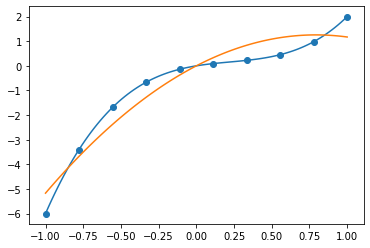

In [7]:
plt.scatter(x, y)
plt.plot(x100, f(x100))
plt.plot(x100, poly(x100))
plt.show()

Довольно ожидаемо, наша функция (оранжевая) не очень похожа на то, что мы искали (синяя). Наверное зря мы пытаемся приблизить кубическую функцию многочленом второй степени. Давайте попробуем 3-ю степень.

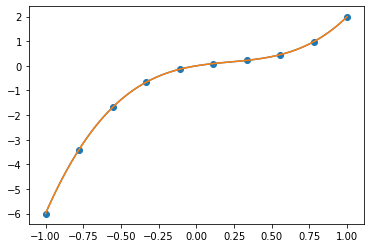

In [8]:
coefs = np.polyfit(x, y, deg = 3)
poly = np.poly1d(coefs)
plt.scatter(x, y)
plt.plot(x100, f(x100))
plt.plot(x100, poly(x100))
plt.show()

На этот раз мы в точности угадали функцию. Можете проверить, что если увеличивать степень многочлена, результат не меняется: более высокие степени тут просто не нужны.

Но мы сейчас жили в идеальном мире. На практике чаще всего известные нам значения не совсем точны. Давайте добавим к значениям нашей функции немного шума:

In [75]:
def f_real(x):
    return 3 * x ** 3 - 2 * x**2 + x + np.random.normal(0, 1, x.shape)

In [76]:
x.shape

(10,)

In [80]:
x = np.linspace(-1, 1, 10)
y = f_real(x) # + np.random.normal(0, 0.5, 10)  # случайный шум

In [81]:
x100 = np.linspace(-1, 1, 100)

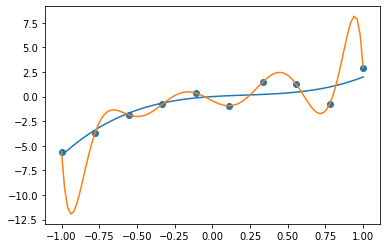

In [82]:
coefs = np.polyfit(x, y, deg = 10)
poly = np.poly1d(coefs)
plt.scatter(x, y)
plt.plot(x100, f(x100))
plt.plot(x100, poly(x100))
plt.show()

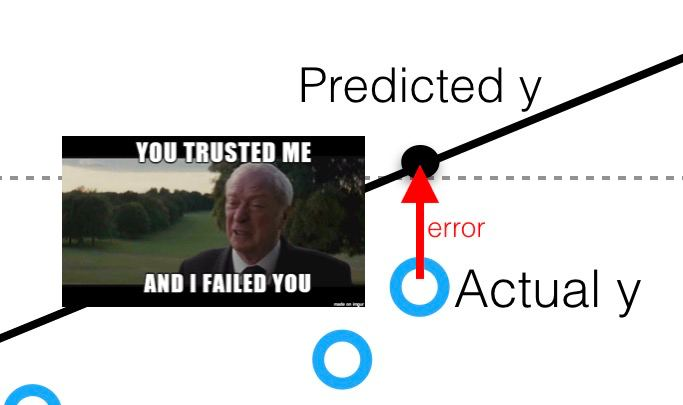

Теперь мы почти попали. Перед тем как читать дальше, подумайте над заданием.

**(1 балл) Обязательное задание 1:** попробуйте увеличить степень полинома. Что произойдет с графиком нашего приближения? Посмотрите  как обе функции себя ведут вне интервала x. Попробуйте сформулировать проблему, с которой мы столкнулись.

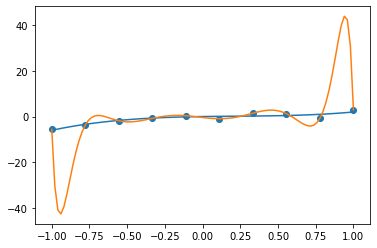

In [83]:
coefs = np.polyfit(x, y, deg = 20)
poly = np.poly1d(coefs)
plt.scatter(x, y)
plt.plot(x100, f(x100))
plt.plot(x100, poly(x100))
plt.show()

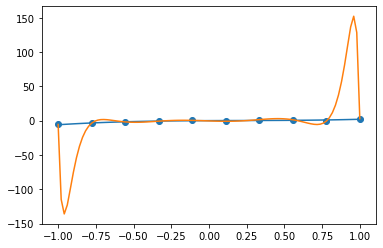

In [84]:
coefs = np.polyfit(x, y, deg = 50)
poly = np.poly1d(coefs)
plt.scatter(x, y)
plt.plot(x100, f(x100))
plt.plot(x100, poly(x100))
plt.show()

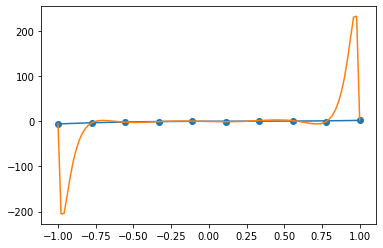

In [85]:
coefs = np.polyfit(x, y, deg = 100)
poly = np.poly1d(coefs)
plt.scatter(x, y)
plt.plot(x100, f(x100))
plt.plot(x100, poly(x100))
plt.show()

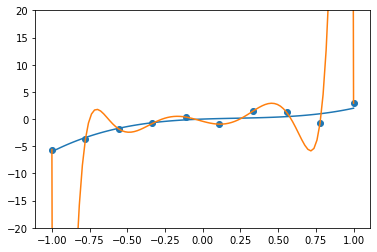

In [86]:
coefs = np.polyfit(x, y, deg = 100)
poly = np.poly1d(coefs)
plt.scatter(x, y)
plt.plot(x100, f(x100))
plt.plot(x100, poly(x100))
plt.ylim([-20, 20])
plt.show()

При увеличении степени полинома между 1-ой и 2-ой точкой и 9-ой и 10-ой точкой значения функции улетает в небо

In [87]:
x100_2 = np.linspace(-10, 10, 100)

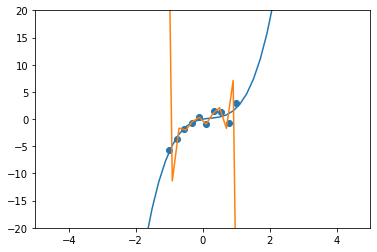

In [88]:
coefs = np.polyfit(x, y, deg = 10)
poly = np.poly1d(coefs)
plt.scatter(x, y)
plt.plot(x100_2, f(x100_2))
plt.plot(x100_2, poly(x100_2))
plt.xlim([-5, 5])
plt.ylim([-20, 20])
plt.show()

За пределами диапазона функция нашего полинома стремительно растет, притом в сторону, отличную от направления роста функции, по которой построены точки.

Это проблема переобучения, о которой и написано ниже...

## 3. Переобучение

То, что вы увидели при решении этого задания называется в машинном обучении **переобучением** (overfittig).

Если мы используем достаточно сложную модель (то есть модель, у которой много параметров, в нашем случае -- многочлен достаточно высокой степени), то у модели появляется возможность "выучить" все точки, которые она видела. Например, если задано $m$ точек, всегда можно подобрать многочлен степени $m-1$, который через них проходит (если вы не знакомы с этим фактом, можете подумать, как его доказать).


"Честный" способ проверять качество нашей апроксимации -- **смотреть точность в точках, которые мы не использовали при подборе многочлена**. Это множество часто называют тестовым множеством. Давайте зададим его так:

In [102]:
# возьмем 10 случайных точек от 0 до 1
x_test = np.random.random(10) 

# превратим их в 10 случайных точек от -1 до 1
x_test = 2 * x_test - 1
y_test = f_real(x_test)
x_test

array([-0.51666271, -0.27172893,  0.9993323 , -0.91786227, -0.93864544,
       -0.05209073,  0.11270507,  0.9530189 ,  0.56485505, -0.11026701])

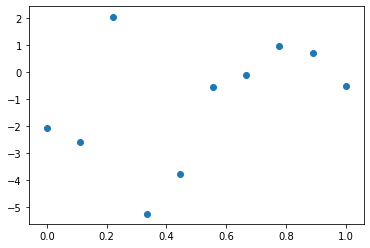

In [103]:
plt.scatter(np.linspace(0, 1, 10), y_test)
plt.show()

**(1 балл)  Обязательное задание 2:** напишите функцию, которая для данного многочлена считает его качество на тестовом множестве (то есть среднеквадратичное отклонение между значениями функции $f$ и многочлена $P$ на тестовой выборке).

Вы все прошлое занятие изучали разные функции, попробуйте сделать MSE как можно более компактной функцией (желательно в одну строчку).

In [91]:
# y_real - это np.array c реальными значениями в точках
# y_pred - это np.array c предсказанными нами значениями в точках
# они одной длины
def MSE(y_real, y_pred):
    return np.sum(np.power((y_real - y_pred), 2)) / y_real.shape[0]

In [100]:
from sklearn.metrics import mean_squared_error
y_r = np.random.rand(10)*10
y_p = np.random.rand(10)*10

In [93]:
print(MSE(y_r, y_p))
print(mean_squared_error(y_r, y_p))

26.03101149011369
26.03101149011369


**(1 балл) Обязательное задание 3:** нарисуйте график зависимости ошибки на тестовом множестве от степени многочлена. При какой степени ошибка минимальна?


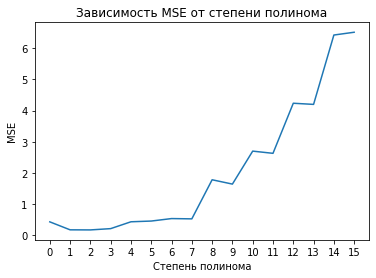

In [104]:
mse_list = []
max_deg = 16
for i in range(max_deg):
    coefs = np.polyfit(x, x_test, deg = i)
    poly = np.poly1d(coefs)
    mse_list.append(mean_squared_error(x_test, poly(x_test)))
plt.plot(np.arange(max_deg), mse_list)
plt.xticks(np.arange(max_deg))
plt.title("Зависимость MSE от степени полинома")
plt.xlabel('Степень полинома')
plt.ylabel('MSE')
plt.show()

MSE минимальна при степени полинома равной 3

**(1 балл) Доп. задача 5:** как меняется график, если увеличивать количество точек в множестве, на котором мы подбираем многочлен?

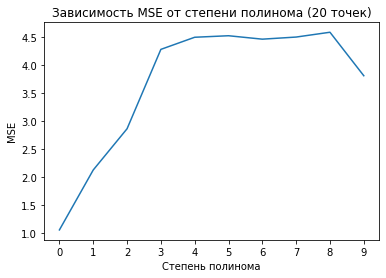

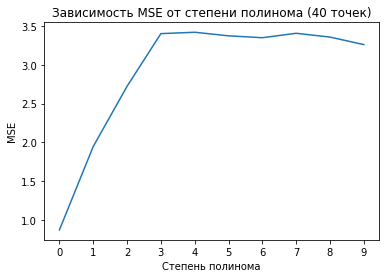

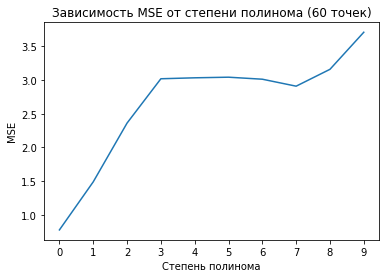

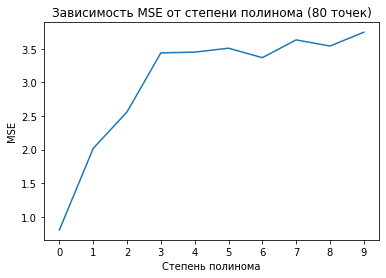

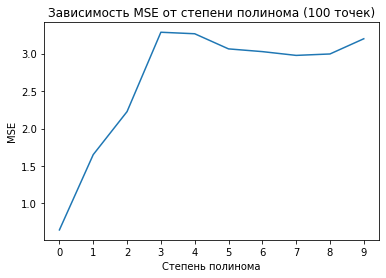

In [106]:
max_deg = 10
num_points = 5
for i in range(num_points):
    mse_list = []
    x = np.linspace(-1, 1, num_points * 20)
    y = f_real(x)
    for j in range(max_deg):
        coefs = np.polyfit(x, y, deg = j)
        poly = np.poly1d(coefs)
        mse_list.append(mean_squared_error(x_test, poly(x_test)))
    plt.plot(np.arange(max_deg), mse_list)
    plt.xticks(np.arange(max_deg))
    plt.title(f"Зависимость MSE от степени полинома ({(i + 1) * 20} точек)")
    plt.xlabel('Степень полинома')
    plt.ylabel('MSE')
    plt.show()

MSE становится меньше, так как больше данных для точного обучения

## 4. Выводы

1. Цель машинного обучения с учителем - приблизить **целевую функцию** (target) по её значениям (возможно приблзительным) в некоторых точках.

В нашем случае - это $f(x) = 3x^3 - 2x^2 + x$. Обычно она, конечно, никому неизвестна.

2. Множество точек с известным значением функции называется **тренировочным множеством** (train).

В нашем случае - это 10 точек, выбранных равномерно на отрезке $[-1, 1]$.

3. Чтобы приблизить функцию, нужно использовать какую-то **модель** (model), приближающую функцию.

В данном случае - это многочлен $P(x) = a_0 + a_1x + a_2x^2 + \ldots + a_nx^n$.

4. Мы выбираем **функцию потерь** (loss function) для сравнения результатов модели и реальных значения на тренировочном множестве. Чем она меньше, тем лучше наша модель.

В данном случае - это $MSE = \sum_i (P(x_i) - f(x_i))^2$.

5. У модели есть **параметры**, которые мы выбираем так, чтобы функция потерь на тренировочном множестве была минимальна.

В данном случае - это коэффициенты многочлена ($a_0, a_1, \ldots, a_n$). Выбираются они с помощью пока магической для нас функции polyfit.

6. У модели есть **гиперпараметры**, которые мы выбираем сами.

В данном случае - это степень многочлена (число $n$).

7. Однако такой подход с минимизацией функции потерь может привести к тому, что мы идеально приблизим функцию на тренировочном множестве, но она будет абсолютно отличаться во всех остальных точках. Это явление называется **переобучением**.

В данном случае - мы видели, что если степень многочлена большая (больше трех), то мы попадаем во все точки, но при этом сам многочлен сильно отличается от $f(x)$.

8. Чтобы бороться с переобучением, полезно выделить **тестовое множество** точек, в которых мы тоже знаем результаты функции. Оно никак не используется при обучении модели, и нужно только для валидации результата.

В данном случае - мы взяли рандомные 10 точек на отрезке $[-1, 1]$.

9. В идеальном случае функция потерь на тренировочном и тестовом множестве не отличается. А вот если на тренировочном функция потерь получается гораздо меньше, чем на тестовом, то это говорит о том, что происходит переобучение.

Действительно, при большой степени MSE близка к или равна нулю на тренировочном множестве, а на тестовом множестве нет.

10. Единственный пока способ, который мы знаем, чтобы влиять на переобучение - это перебирать **гиперпараметры** модели так, чтобы **минимизировать функцию потерь на тестовом множестве**.

Действительно, если выбрать степень 3, то функция потерь окажется минимальной на тестовом множестве, как мы видели в задании 3.

## 5. Разделение на тренировочную и тестовую части

Если вы решите поучаствовать в каком-нибудь соревновании по машинному обучению, вы увидите, что тестовое множество вам недоступно (иначе было бы неинтересно: очень легко обучиться предсказывать то, что ты уже видел).

В реальной жизни обычно тоже считают, что на тестовом множестве можно провериться один раз -- в самом конце. Иначе вы начнете подкручивать гиперпараметры глядя на результат на тестовой выборке и, сами того не замечая, переобучитесь.

Как поступать в такой ситуации? Придется пожертвовать частью точек, которые даны нам для обучения и использовать их для подбора гиперпараметров в нашем алгоритме (в нашем случае это степень многочлена).

То есть придется из точек, у которых мы знаем результаты, убрать, например, 10% в тестовое множество.

Функция для этого есть, например, в пакете sklearn

In [14]:
X = np.linspace(-1, 1, 50)
y = f_real(X)

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [16]:
X_train, y_train

(array([ 0.79591837,  0.02040816,  0.75510204,  0.3877551 ,  0.87755102,
         0.26530612,  0.18367347,  0.42857143, -0.87755102,  0.55102041,
         0.95918367, -0.34693878, -0.2244898 ,  0.2244898 ,  0.71428571,
        -0.46938776, -0.3877551 ,  0.14285714,  0.91836735,  0.83673469,
        -0.26530612,  0.51020408, -0.67346939, -0.14285714, -0.42857143,
        -0.02040816, -0.55102041,  0.67346939, -0.59183673,  0.63265306,
         0.10204082, -0.75510204, -0.30612245, -0.79591837,  0.34693878,
         0.06122449,  1.        , -1.        , -0.18367347, -0.63265306,
        -0.51020408,  0.59183673, -0.95918367,  0.30612245, -0.91836735]),
 array([-0.02125219,  0.87369454,  0.50536695, -0.62265544,  1.58518449,
         0.22043412,  0.60529311, -0.20481953, -5.57593799, -0.04718957,
         2.00629626, -0.20973713,  1.42955208,  0.82103645,  3.21587192,
        -3.06760304, -1.33212726,  1.59579191,  3.2182928 ,  0.2732048 ,
        -0.07144245, -0.48355358, -3.79688598, -0

In [17]:
X_test, y_test

(array([-0.83673469,  0.46938776, -0.10204082, -0.71428571, -0.06122449]),
 array([-4.14163236,  0.71017196, -1.57890646, -4.44045902,  0.04627564]))

## 6. Кросс-валидация

Также есть более точный способ проводить валидацию результата. Если разделить множество один раз на тестовое и тренировочное, то это может значительно влиять на результат. Вдруг в тестовое множество случайно попали такие точки, в которых предсказать значение тяжелее или легче, чем обычно?

Тогда можно применить **кросс-валидацию** - давайте разделим множество на 10 примерно равных частей, тогда у нас есть 10 разделений на тренировочное и тестовое множество - как тестовое множество выберем по очереди каждую из этих частей, а как тренировочное выберем все остальные части. В итоге, все элементы множества побывают и в тренировочной, и в тестовой чати.

Можно посчитать результат на каждом из 10 разбиений и просто усреднить результат.


In [18]:
# Есть вот такая удобная штука
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
kf.get_n_splits(X)
for train_index, test_index in kf.split(X):
    print(test_index, train_index)

[0 1 2 3 4] [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
[5 6 7 8 9] [ 0  1  2  3  4 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
[10 11 12 13 14] [ 0  1  2  3  4  5  6  7  8  9 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
[15 16 17 18 19] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
[20 21 22 23 24] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
[25 26 27 28 29] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
[30 31 32 33 34] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20

**(1 балл) Доп. задача 6:** проделайте все вышеописанное с функцией $f(x) = \frac{1}{1 + e^{-x}}$ на отрезке $[-3, 3]$. Как оптимальная степень зависит от количества точек, по которым вы подбираете многочлен?

1. Построить заданную функцию

2. Взять 10 точек от -3 до 3 и приближать её полиномом разной степени, построить график ошибки

3. Взять 10 случайных точек от -3 до 3 и посмотреть ошибку на этих точках полиномиальных функций обученных по пункту 2 (т.е. взять тренировочные точки для обучения из пункта 2, а тестировать случайными точками) построить график.

4. Добавить в функцию случайный шум и проделать пункты 2 и 3 для неё.

5. Увеличить количество тренировочных(только тренировочных) точек с 10 например до 20 40 60. И проделать пункты 2 и 3, для этих сэмплов

6. Сделать выводы.

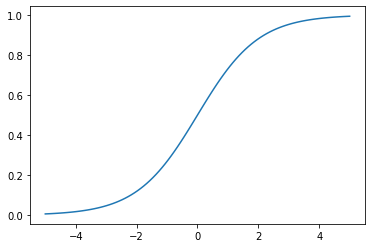

In [134]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.linspace(-5, 5, 100)
plt.plot(x, sigmoid(x))
plt.show()

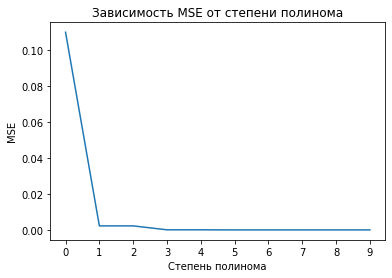

In [136]:
# x = np.linspace(-3, 3, 10)
# coefs = np.polyfit(x, sigmoid(x), deg=10)
# poly = np.poly1d(coefs)
# plt.plot(x, poly(x), color='y')
# plt.plot(x, sigmoid(x), color='k')
# plt.show()
max_deg = 10
mse_list = []
x = np.linspace(-3, 3, 10)
y = sigmoid(x)
for j in range(max_deg):
    coefs = np.polyfit(x, y, deg = j)
    poly = np.poly1d(coefs)
    mse_list.append(mean_squared_error(y, poly(x)))
plt.plot(np.arange(max_deg), mse_list)
plt.xticks(np.arange(max_deg))
plt.title("Зависимость MSE от степени полинома")
plt.xlabel('Степень полинома')
plt.ylabel('MSE')
plt.show()

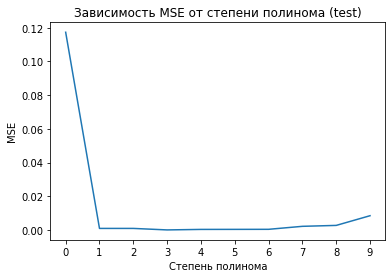

In [139]:
mse_list = []
max_deg = 10
x_test = np.sort(np.random.uniform(-3, 3, 10))
y_test = sigmoid(x_test)
for j in range(max_deg):
    coefs = np.polyfit(x, y, deg = j)
    poly = np.poly1d(coefs)
    mse_list.append(mean_squared_error(y_test, poly(x_test)))
    # if j == 4:
    #     plt.plot(x_test, poly(x_test), color='y')
    #     plt.plot(x_test, y_test, color='k')
    #     plt.show()
plt.plot(np.arange(max_deg), mse_list)
plt.xticks(np.arange(max_deg))
plt.title("Зависимость MSE от степени полинома (test)")
plt.xlabel('Степень полинома')
plt.ylabel('MSE')
plt.show()

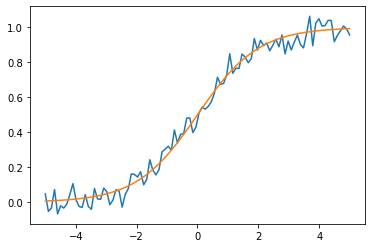

In [135]:
def sigmoid_real(x):
    return 1 / (1 + np.exp(-x)) + np.random.normal(0, 0.05, len(x))
x = np.linspace(-5, 5, 100)
plt.plot(x, sigmoid_real(x))
plt.plot(x, sigmoid(x))
plt.show()

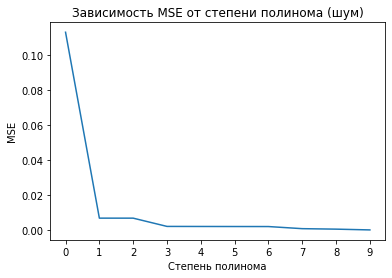

In [140]:
max_deg = 10
mse_list = []
x = np.linspace(-3, 3, 10)
y = sigmoid_real(x)
for j in range(max_deg):
    coefs = np.polyfit(x, y, deg = j)
    poly = np.poly1d(coefs)
    mse_list.append(mean_squared_error(y, poly(x)))
plt.plot(np.arange(max_deg), mse_list)
plt.xticks(np.arange(max_deg))
plt.title("Зависимость MSE от степени полинома (шум)")
plt.xlabel('Степень полинома')
plt.ylabel('MSE')
plt.show()

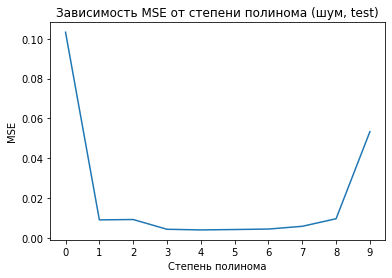

In [141]:
mse_list = []
max_deg = 10
x_test = np.sort(np.random.uniform(-3, 3, 10))
y_test = sigmoid_real(x_test)
for j in range(max_deg):
    coefs = np.polyfit(x, y, deg = j)
    poly = np.poly1d(coefs)
    mse_list.append(mean_squared_error(y_test, poly(x_test)))
    # if j == 4:
    #     plt.plot(x_test, poly(x_test), color='y')
    #     plt.plot(x_test, y_test, color='k')
    #     plt.show()
plt.plot(np.arange(max_deg), mse_list)
plt.xticks(np.arange(max_deg))
plt.title("Зависимость MSE от степени полинома (шум, test)")
plt.xlabel('Степень полинома')
plt.ylabel('MSE')
plt.show()

In [142]:
x20 = np.linspace(-3, 3, 20)
x40 = np.linspace(-3, 3, 40)
x60 = np.linspace(-3, 3, 60)
list_x = [x20, x40, x60]

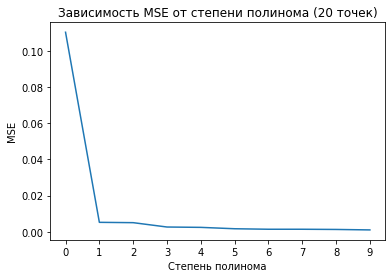

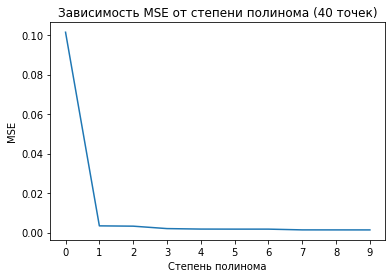

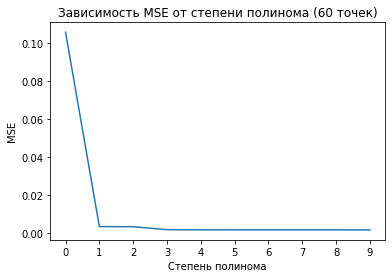

In [143]:
for i in list_x:
    max_deg = 10
    mse_list = []
    y = sigmoid_real(i)
    for j in range(max_deg):
        coefs = np.polyfit(i, y, deg = j)
        poly = np.poly1d(coefs)
        mse_list.append(mean_squared_error(y, poly(i)))
    plt.plot(np.arange(max_deg), mse_list)
    plt.xticks(np.arange(max_deg))
    plt.title(f"Зависимость MSE от степени полинома ({len(i)} точек)")
    plt.xlabel('Степень полинома')
    plt.ylabel('MSE')
    plt.show()

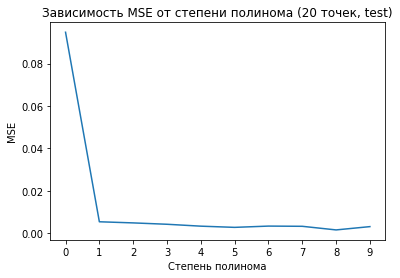

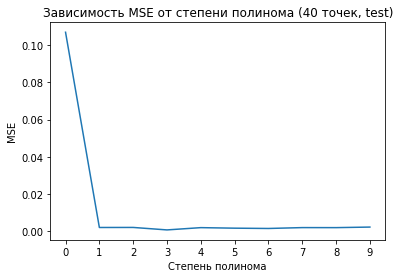

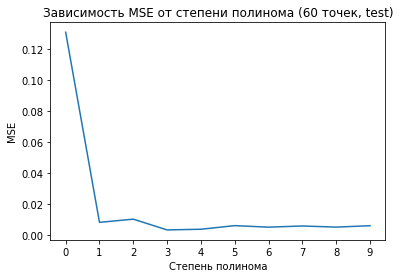

In [148]:
for i in list_x:
    mse_list = []
    max_deg = 10
    x_test = np.sort(np.random.uniform(-3, 3, 10))
    y_test = sigmoid_real(x_test)
    for j in range(max_deg):
        coefs = np.polyfit(i, sigmoid_real(i), deg = j)
        poly = np.poly1d(coefs)
        mse_list.append(mean_squared_error(y_test, poly(x_test)))
    plt.plot(np.arange(max_deg), mse_list)
    plt.xticks(np.arange(max_deg))
    plt.title(f"Зависимость MSE от степени полинома ({len(i)} точек, test)")
    plt.xlabel('Степень полинома')
    plt.ylabel('MSE')
    plt.show()
    # print(mse_list)

Чем больше точек для обучения, чем меньше ошибка на низких степенях, потому что полином не может подстроиться под все точки. А при большой степени полинома ошибка будет еще меньше, но модель переобучится 

## 7. Линейная регрессия на реальных данных

До этого мы учились приближать одномерную функцию многочленом. Каждая точка имела ровно один признак - коодинату $x$.

Тем не менее, чаще всего в машинном обучении признаков гораздо больше. Возьмем какой-нибудь реальный датасет.

In [149]:
# https://drive.google.com/file/d/13kQUcl-N3ag6NXEm-QWjdUiuHO4-LOxb/view?usp=sharing
!gdown --id 13kQUcl-N3ag6NXEm-QWjdUiuHO4-LOxb

"gdown" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [252]:
data = pd.read_csv('Advertising.csv', index_col=0)
data.head()

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


В датасете показаны результаты продаж разных товаров в зависимости от ресурсов (тысяч долларов), которые вложили в различные средства распространения информации:
* TV - реклама по телевизору
* radio - на радио
* newspapers - в газетах

Целевая переменная:

sales - продажи такого-то товара (тысячи штук)

In [152]:
# Размеры датасета
data.shape

(200, 4)

In [153]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
TV           200 non-null float64
Radio        200 non-null float64
Newspaper    200 non-null float64
Sales        200 non-null float64
dtypes: float64(4)
memory usage: 7.8 KB


In [154]:
data.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


Признаков немного, поэтому давайте попробуем визуализиовать зависимость целевой переменной от каждого из признаков.

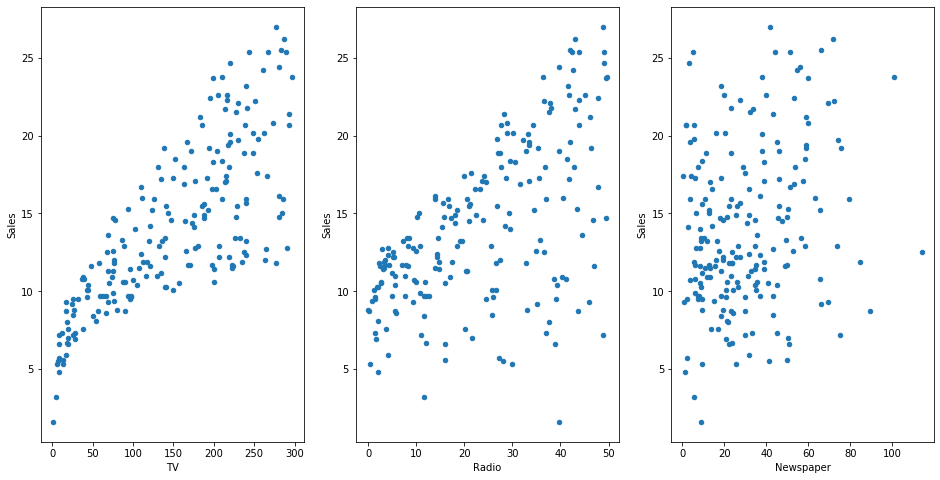

In [155]:
fig, axs = plt.subplots(1, 3,)
data.plot(kind='scatter', x='TV', y='Sales', ax=axs[0], figsize=(16, 8))
data.plot(kind='scatter', x='Radio', y='Sales', ax=axs[1])
data.plot(kind='scatter', x='Newspaper', y='Sales', ax=axs[2])
plt.show()

### Простая линейная регрессия

Из графиков выше предположим, что только размер рекламы на телевизоре влияет на продажи больше всего. Формула для такого случая выглядит следующим образом:
$$y=\beta_0+\beta_1x$$
Здесь:
* $y$ - наше предсказание продаж
* $x$ - сколько денег вложили в рекламу по телевидению
* $\beta_0$ - сдвиг
* $\beta_1$ - параметр, отвечающий за важность признака x

$\beta_0$ и $\beta_1$ - это параметры нашей модели. Чтобы создать хорошую модель, надо "обучить" эти значения. Т.е. изменить их так, чтобы они хорошо работали для нашей задачи.

### Обучение коэффициентов модели

Параметры $\beta_0$ и $\beta_1$ подбираются таким образом, чтобы минимизировать **сумму наименьших квадратов ошибок**:

$$Q(MSE)=\sum_{i=1}^{N}(y^{true}_i-y^{pred}_i)^2$$

<img src="https://i.pinimg.com/originals/95/99/b0/9599b04198dc617282026d00a6e8f9d4.png">

* Фиолетовые точки на даграмме $y^{true}$ - это полученные истинные значения x и y .
* Синяя линия $y^{pred}$ - это наша модель: линия, которой мы стараемся приблизить данные .
* Красные отрезки - это ошибки нашей модели.


Как коэффициенты $\beta_0$ и $\beta_1$ соотносятся с синей линией:
* $\beta_0$ - это сдвиг нашей прямой, т.е. значение y при x = 0.
* $\beta_1$ - это тангенс угла наклона прямой.

Как искать данные коэффициенты? Есть много техник: аналитическое решение, методы основанные на градиентном спуске. Пока же достаточно знать, что многие библиотеки (в том числе и sklearn) умеют это делать. Зачем кожаному мешку напрягаться :)

In [156]:
from sklearn.linear_model import LinearRegression

# Наша модель
reg = LinearRegression()

# Подготовим данные для неё
# На вход требуется 2D матрица, а у нас только один признак,
# и надо превратить его из 1D вектора (n,) в 2D матрицу (n, 1).
# Это можно сделать с помощью метода reshape
x = data["TV"].values.reshape(-1, 1) 
y = data["Sales"].values

# Обучаем нашу модель
reg.fit(x, y)

# Коэффициенты
print("Сдвиг={}".format(reg.intercept_))
print("Массив коэффициентов={}".format(reg.coef_))

Сдвиг=7.032593549127693
Массив коэффициентов=[0.04753664]


### Интерпретируем коэффициенты
Что означает коэффициент, связанный с телевидением ($\beta_1$)?
* Дополнительные 1000 000$, вложенные на в рекламу на телевидении, позволят продажам товара вырасти где-то на 0.047 * 1000 = 47 тысяч единиц.

In [157]:
# Посчитаем ручками
7.032594 + 0.047537*1000

54.56959400000001

In [158]:
X_new = pd.DataFrame({'TV': [1000]})
X_new.head()

,TV
0,1000


In [159]:
reg.predict(X_new)

array([54.56923398])

### Нарисуем нашу прямую

In [160]:
# Возьмём предсказания для данных, на которых обучались
y_pred = reg.predict(x)
y_pred.shape

(200,)

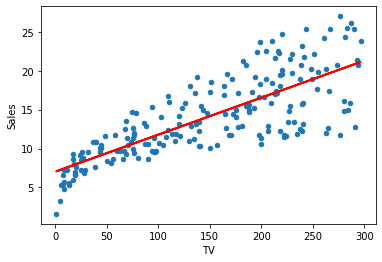

In [161]:
# Сначала выведем истинные данные
data.plot(kind='scatter', x='TV', y='Sales')

# Теперь рисуем нашу линию
plt.plot(x, y_pred, c='red', linewidth=2)
plt.show()

Посчитаем ошибку MSE на обучающей выборке:


In [162]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(y_pred, y))

10.512652915656757


### Используем все признаки

Простую линейную регрессию с одним признаком можно легко расширить на случай нескольких признаков:
$$y=\beta_0+\beta_1x_1+...+\beta_nx_n$$

А для нашего датасета это будет выглядеть так:
$$Sales=\beta_0+\beta_1*TV+\beta_2*radio+\beta_3*newspaper$$

Давайте опять воспользуемся sklearn, чтобы их оценить:

In [163]:
reg = LinearRegression()

X = data.drop("Sales", axis=1)
y = data["Sales"]

# Обучаем нашу модель
reg.fit(X, y)

# Коэффициенты
print("Сдвиг = {}".format(reg.intercept_))
for column, coef in zip(X.columns, reg.coef_):
    print("Коэффициент для {} = {}".format(column, coef))

Сдвиг = 2.9388893694594067
Коэффициент для TV = 0.04576464545539761
Коэффициент для Radio = 0.18853001691820462
Коэффициент для Newspaper = -0.0010374930424762972


Вес признака отвечает также, как и в предыдущем случае за значимость этого признака. Для газет он вообще отрицательный. Вычислим ошибку на обучающей выборке.

In [164]:
y_pred = reg.predict(X)

# Ошибка теперь равна:
print(mean_squared_error(y_pred, y))

2.784126314510936


Ошибка уже меньше, чем при одном признаке, однако измерять ошибку на обучающей выборке неправильно. Помимо истинной зависимости между признаками и целевой переменной, туда могут затесаться случайности, лишние данные и прочие факторы. Если не ограничивать каким-то образом модель (об этом мы узнаем позднее), то модель легко подстраивается под эти шумы. Она начинает показывать очень хорошее качество на обучающей выборке, но когда мы попробуем посмотреть качество на других выборках, то там модель будет показывать себя плохо. Это и есть переобучение.

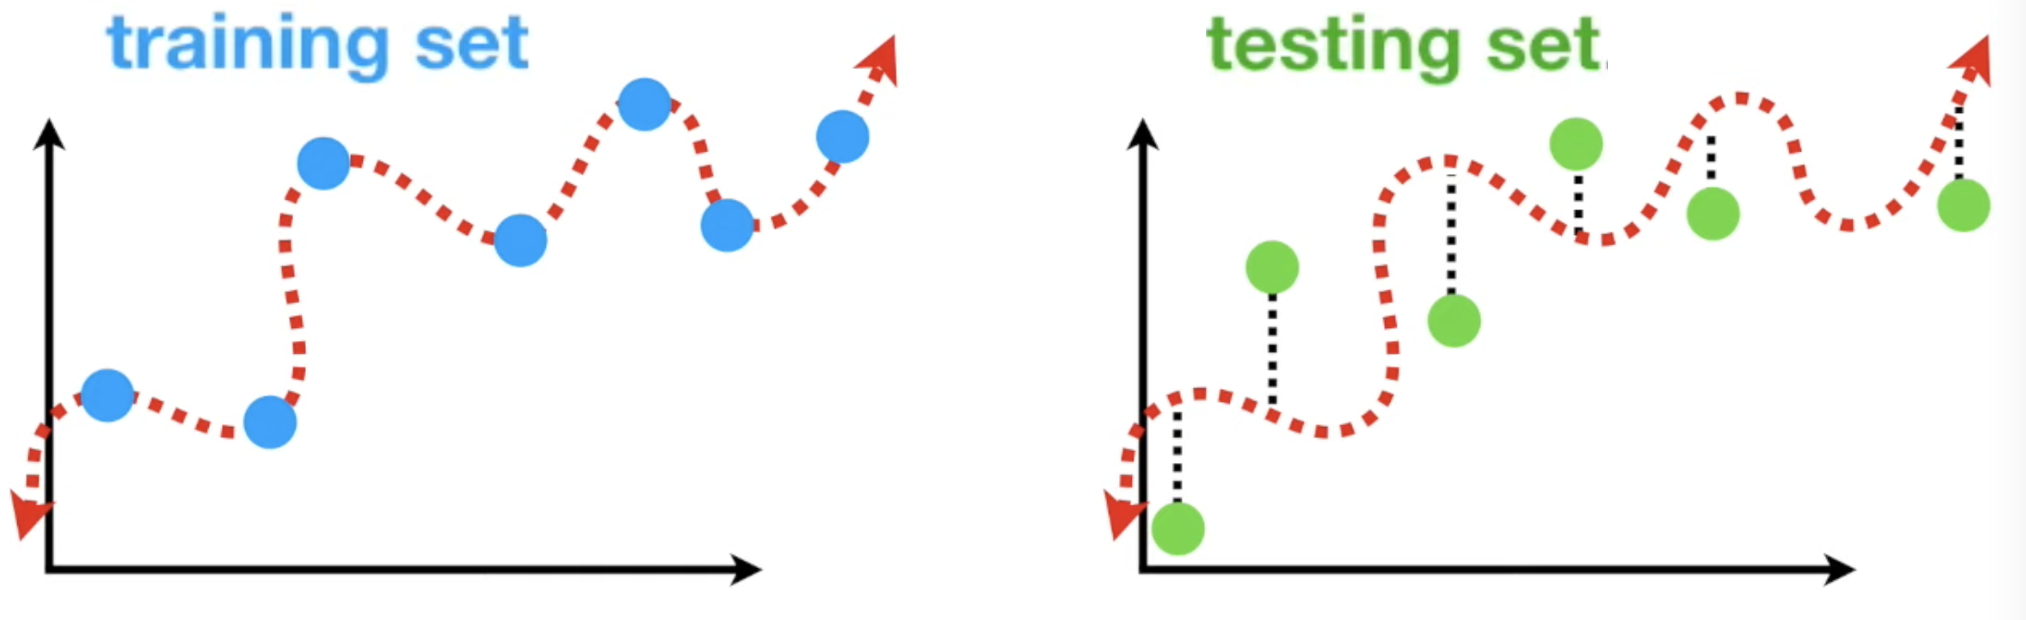

Поэтому применим кросс-валидацию:

In [253]:
# Многие выбирают k=5 для начала
k = 5
errors = []

X = data.drop("Sales", axis=1)
y = data["Sales"]

# Размер одной части
fold_size = len(X) // k


for i in range(k):
    # Берём все значения, кроме выбранной части
    X_train = X[:i * fold_size].append(X[(i + 1) * fold_size:])
    y_train = y[:i * fold_size].append(y[(i + 1) * fold_size:])
    
    # Берём выбранную часть
    X_test = X[i * fold_size:(i + 1) * fold_size]
    y_test = y[i * fold_size:(i + 1) * fold_size]
    
    # На каждой итерации обучаемся отдельно и сохраняем ошибку
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    errors.append(mean_squared_error(y_pred, y_test))
    
# Выводим ошибку на кросс-валидации
print(np.mean(errors))

3.07294659710021


In [167]:
# А можно не париться и попросить sklearn всё сделать за нас
from sklearn.model_selection import cross_val_score

# Берём с отрицательным знаком, т.к. обычно туда передаётся не функция потерь, которую надо минимизировать
# А что-то вроде "функции успеха", которую надо максимизировать
errors = -cross_val_score(LinearRegression(), X, y, cv=5, scoring='neg_mean_squared_error')
print(np.mean(errors))

3.07294659710021


Видно, что ошибка больше, чем тогда на обучающей выборке, поэтому есть показания думать, что это переобучение. Отчего оно обычно происходит? Мы берём слишком много лишних признаков или делаем модель слишком сложной для данной задачи. Для решения этой задачи существует регуляризация.

### Регуляризация

Регуляризация - это искусстенное занижение всех параметров моделей ($\beta_0,\beta_1,...$). Это помогает упростить модель, т.к. низкие значения $\beta_i$ означают, что модель будет выдавать результаты близкие к прямой (или гиперплоскости, если параметров много). А также зануление некоторых коэффициентов может убрать ненужные признаки из обучения. Однако как всё это сделать так, чтобы не убрать нужные признаки?

Посмотрим на функцию потерь, которую мы минимизируем:
$$L(\beta)=\sum_{i=1}^{N}(y^{true}_i-y^{pred}_i)^2$$

Добавим туда слагаемое, которое поможет нам понизить значения наших $\beta_i$:
$$L(\beta)=\sum_{i=1}^{N}(y^{true}_i-y^{pred}_i)^2 + \lambda \sum_{i=1}^m\beta_i^2$$

Действительно, если мы будем понижать нашу функцию потерь $L(\beta)$, то мы будем минимизировать и второе слагаемое, которое и отвечает за абсолютные величины $\beta_i$. Осталось указать, что $\lambda$ это некоторый числовой коэффициент, который позволяет играться между очень сильной и очень слабой регуляризацией. Если он большой, то регуляризация сильная и модель будет более простой, меньше переобучаться, больше недообучаться, и наоброт. 

Забыл добавить, что это была L2-регуляризация.
L1-регуляризация выглядит так:
$$L(\beta)=\sum_{i=1}^{N}(y^{true}_i-y^{pred}_i)^2 + \lambda \sum_{i=1}^m|\beta_i|$$
Она отличается от L2 тем, что она обнуляет некоторые коэффициенты, а L2 пытается всё уменьшать равномерно.

В sklearn L1-регуляризация - это Lasso, а L2-регуляризация - это Ridge. Давайте посмотрим, какое качество они нам дадут на кросс-валидации.

In [168]:
# L1
from sklearn.linear_model import Lasso

reg = Lasso( ).fit(X, y)

# Посмотрим на коэффициенты модели
# Коэффициенты
print("Сдвиг={}".format(reg.intercept_))
for column, coef in zip(X.columns, reg.coef_):
    print("Коэффициент для {}={}".format(column, coef))
print()

errors = -cross_val_score(Lasso(), X, y, cv=5, scoring='neg_mean_squared_error')
print("Результат={}".format(np.mean(errors)))

Сдвиг=3.0402155834803786
Коэффициент для TV=0.045661415380019464
Коэффициент для Radio=0.18346439758868255
Коэффициент для Newspaper=0.0

Результат=3.041405896751369


Видно, что признак с рекламой в газетах модель захотела полностью убрать из выборки.

In [169]:
# L2
from sklearn.linear_model import Ridge

reg = Ridge( ).fit(X, y)

# Посмотрим на коэффициенты модели
# Коэффициенты
print("Сдвиг = {}".format(reg.intercept_))
for column, coef in zip(X.columns, reg.coef_):
    print("Коэффициент для {} = {}".format(column, coef))
print()

errors = -cross_val_score(Ridge(), X, y, cv=5, scoring='neg_mean_squared_error')
print("Результат={}".format(np.mean(errors)))

Сдвиг = 2.9389674583301524
Коэффициент для TV = 0.04576464365801847
Коэффициент для Radio = 0.1885250968107854
Коэффициент для Newspaper = -0.0010362939589069462

Результат=3.0729326732984985


In [170]:
reg.coef_

array([ 0.04576464,  0.1885251 , -0.00103629])

Тут модель полностью не зануляла все признаки, а уменьшила их веса некоторых из них, а некоторых увеличила. Но изменения были столь незначительные, что качество не изменилось.

Как видно, качество не сильно улучшилось. Это всё потому что, мы не подбирали параметр параметр lambda (в моделях он называется alpha), а оставили его равным 1.0. Вот тут нам и приходит на помощь кросс-валидация.

Попробуем сначала Lasso. Давайте сначала поступим по тупому, и будем выбирать параметр lambda на обучающей выборке.

In [171]:
lambdas = np.arange(0.1, 3.0, 0.2)
# Выведем доступные lambda
print("Все лямбды:")
print(lambdas)

# Лямбды и их ошибки на обучающей выборке
lambda_errors = []

# Проходим по всем лямбдам и записываем ошибки на обучающей выборке
for val in lambdas:
    reg = Lasso(alpha=val).fit(X, y)
    y_pred = reg.predict(X)
    # Сохраняем ошибку на обучающей выборке
    lambda_errors.append((val, mean_squared_error(y_pred, y)))
    print(((val, mean_squared_error(y_pred, y))))
    

min_val, min_train_error = min(lambda_errors, key=lambda x: x[1])

# Вычислим ошибку на кросс-валидации
# Лучшая модель
best_reg = Lasso(alpha=min_val)
cv_error = -np.mean(cross_val_score(best_reg, X, y, cv=5, scoring='neg_mean_squared_error'))

print("\nОптимальная lambda:")
print("Lambda={:.2f}, результат={:.2f}".format(min_val, cv_error))

Все лямбды:
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5 1.7 1.9 2.1 2.3 2.5 2.7 2.9]
(0.1, 2.7842286851696874)
(0.30000000000000004, 2.784985993046452)
(0.5000000000000001, 2.7857256993570276)
(0.7000000000000001, 2.7868352725638887)
(0.9000000000000001, 2.7883147049707757)
(1.1000000000000003, 2.790163996577688)
(1.3000000000000003, 2.7923831473846246)
(1.5000000000000004, 2.7949721573915864)
(1.7000000000000004, 2.797931026598574)
(1.9000000000000004, 2.801259755005587)
(2.1000000000000005, 2.8049583426126237)
(2.3000000000000007, 2.809026789419686)
(2.5000000000000004, 2.813465095426773)
(2.7000000000000006, 2.8182732606338856)
(2.900000000000001, 2.8234512850410236)

Оптимальная lambda:
Lambda=0.10, результат=3.07


А теперь сделайте так, чтобы сохранялась ошибка не на обучающей выборке, а на кросс-валдиации (cross_val_score) и минимум выбирался из неё. 

**(0.5 балла) Обязательное задание 4:** нарисуйте график зависимости ошибки на тестовом множестве от коэффициента регуляризации. При какой степени ошибка минимальна?

In [196]:
lambdas = np.arange(0.1, 3.0, 0.2)
print("Все лямбды:")
print(lambdas)
lambda_errors = []
errors = []

for val in lambdas:
    reg = Lasso(alpha=val).fit(X, y)
    y_pred = reg.predict(X)
    # Сохраняем ошибку на обучающей выборке
    lambda_errors.append((val, np.mean(-cross_val_score(reg, X, y, cv=5, scoring='neg_mean_squared_error'))))
    print((val, np.mean(-cross_val_score(reg, X, y, cv=5, scoring='neg_mean_squared_error'))))
    errors.append(np.mean(-cross_val_score(reg, X, y, cv=5, scoring='neg_mean_squared_error')))

min_val, min_train_error = min(lambda_errors, key=lambda x: x[1])


print("\nОптимальная lambda:")
print("Lambda={:.2f}, результат={:.2f}".format(min_val, min_train_error))

Все лямбды:
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5 1.7 1.9 2.1 2.3 2.5 2.7 2.9]
(0.1, 3.0690219733034056)
(0.30000000000000004, 3.061683260339998)
(0.5000000000000001, 3.0547695900871674)
(0.7000000000000001, 3.0487136047625327)
(0.9000000000000001, 3.043692387539143)
(1.1000000000000003, 3.0392688178462084)
(1.3000000000000003, 3.0354428956837283)
(1.5000000000000004, 3.0325007271616378)
(1.7000000000000004, 3.03030673111868)
(1.9000000000000004, 3.0287560232276873)
(2.1000000000000005, 3.0313984713406734)
(2.3000000000000007, 3.0344600664529815)
(2.5000000000000004, 3.0379444882974136)
(2.7000000000000006, 3.042610388366665)
(2.900000000000001, 3.0476625585776262)

Оптимальная lambda:
Lambda=1.90, результат=3.03


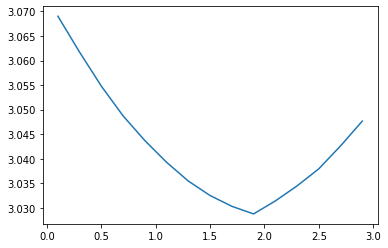

In [197]:
plt.plot(lambdas, errors)
plt.show()

**(0.5 балла) Обязательное задание 5:** Сделайте то же самое для L2-регуляризации:

In [258]:
lambdas = np.arange(1, 1000, 5)
print("Все лямбды:")
print(lambdas)
lambda_errors_2 = []
errors_2 = []

for val in lambdas:
    reg = Ridge(alpha=val).fit(X, y)
    y_pred = reg.predict(X)
    # Сохраняем ошибку на обучающей выборке
    lambda_errors_2.append((val, np.mean(-cross_val_score(reg, X, y, cv=5, scoring='neg_mean_squared_error'))))
    # print((val, np.mean(-cross_val_score(reg, X, y, cv=5, scoring='neg_mean_squared_error'))))
    errors_2.append(np.mean(-cross_val_score(reg, X, y, cv=5, scoring='neg_mean_squared_error')))

min_val_2, min_train_error_2 = min(lambda_errors_2, key=lambda x: x[1])


print("\nОптимальная lambda:")
print("Lambda={:.2f}, результат={:.2f}".format(min_val_2, min_train_error_2))

Все лямбды:
[  1   6  11  16  21  26  31  36  41  46  51  56  61  66  71  76  81  86
  91  96 101 106 111 116 121 126 131 136 141 146 151 156 161 166 171 176
 181 186 191 196 201 206 211 216 221 226 231 236 241 246 251 256 261 266
 271 276 281 286 291 296 301 306 311 316 321 326 331 336 341 346 351 356
 361 366 371 376 381 386 391 396 401 406 411 416 421 426 431 436 441 446
 451 456 461 466 471 476 481 486 491 496 501 506 511 516 521 526 531 536
 541 546 551 556 561 566 571 576 581 586 591 596 601 606 611 616 621 626
 631 636 641 646 651 656 661 666 671 676 681 686 691 696 701 706 711 716
 721 726 731 736 741 746 751 756 761 766 771 776 781 786 791 796 801 806
 811 816 821 826 831 836 841 846 851 856 861 866 871 876 881 886 891 896
 901 906 911 916 921 926 931 936 941 946 951 956 961 966 971 976 981 986
 991 996]

Оптимальная lambda:
Lambda=901.00, результат=3.07


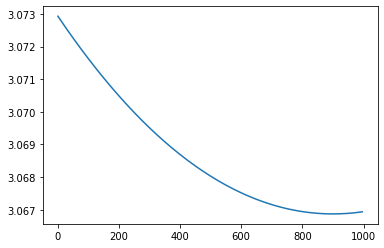

In [259]:
plt.plot(lambdas, errors_2)
plt.show()

Если всё было правильно, то данные манипуляции помогут немного улучшить качество вашей модели. Это поднимет вас на несколько мест в соревнованиях, или вашему работодателю даст побольше прибыли.

## P.S. meme

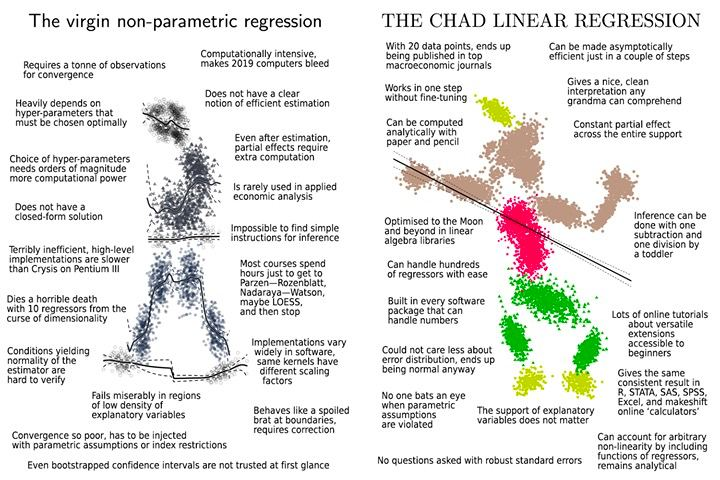

## Дополнительные материалы для самостоятельного изучения

* Визуальное представление основ линейной алгебры [здесь](https://www.youtube.com/playlist?list=PLZHQObOWTQDPD3MizzM2xVFitgF8hE_ab). (рус. субтитры)

* Визуальное представление основ математического анализа [здесь](https://www.youtube.com/playlist?list=PLZHQObOWTQDMsr9K-rj53DwVRMYO3t5Yr). (рус. субтитры)

# Основное домашнее задание (6 баллов + гешефт за улучшения)

In [ ]:
# https://drive.google.com/file/d/1dXl0DeoYG1mkXya6mDpaY0NhbcbI17Nu/view?usp=sharing
! gdown --id 1dXl0DeoYG1mkXya6mDpaY0NhbcbI17Nu

Downloading...
From: https://drive.google.com/uc?id=1dXl0DeoYG1mkXya6mDpaY0NhbcbI17Nu
To: /content/diabetes.data.csv
100% 18.5k/18.5k [00:00<00:00, 14.4MB/s]


Для домашнего задания вы используете другой датасет.

In [260]:
data = pd.read_csv('diabetes.data.csv', sep='\t')
data.head()

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87,151
1,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69,75
2,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85,141
3,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89,206
4,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80,135


В датасете приводится информация о пациентах и их состоянии при заболевании диабетом. Описание признаков можно прочитать [здесь](https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html). Колонка Y - целевая переменная:

In [261]:
target = 'Y'
X = data.drop([target], axis=1)
y = data[target]

X.shape, y.shape

((442, 10), (442,))

**Ваша задача** - провести то же исследование, что и в датасете в самом начале (Sales ~ TV, Radio, Newspaper). В итоге, нужно получить модель линейной регрессии, качество которой надо вывести с помощью cross_val_score с метрикой MSE (тоже самое в общем).

**Целевая метрика - MSE**

За каждое достойное улучшение качества на cross_val_score будут доп. баллы. Не забудьте описать, что использовали, что получилось и нет, а также попробуйте понять почему. Побольше гуглите. 

Возможные улучшения:
* Нормализация данных: вычитаем из каждой колонки её среднее и делим на стандартное отклонение.
* Пробуйте убрать ненужные признаки.
* Можно перемножать некоторые признаки.
* Погуглите что-то вроде "improve linear regression".

В общем, представьте, что вы работаете датасаентистом, получаете *300K bucks*, а вам сказали, что нужно как можно лучше уметь предсказывать такие данные.

Потыкаем что-нибудь...

In [208]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
AGE    442 non-null int64
SEX    442 non-null int64
BMI    442 non-null float64
BP     442 non-null float64
S1     442 non-null int64
S2     442 non-null float64
S3     442 non-null float64
S4     442 non-null float64
S5     442 non-null float64
S6     442 non-null int64
Y      442 non-null int64
dtypes: float64(6), int64(5)
memory usage: 38.1 KB


In [235]:
data.isnull().sum()

AGE    0
SEX    0
BMI    0
BP     0
S1     0
S2     0
S3     0
S4     0
S5     0
S6     0
Y      0
dtype: int64

In [236]:
data.isna().sum()

AGE    0
SEX    0
BMI    0
BP     0
S1     0
S2     0
S3     0
S4     0
S5     0
S6     0
Y      0
dtype: int64

Пропусков нет

In [209]:
data.describe()

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
count,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000
mean,48.518100,1.468326,26.375792,94.647014,189.140271,115.439140,49.788462,4.070249,4.641411,91.260181,152.133484
std,13.109028,0.499561,4.418122,13.831283,34.608052,30.413081,12.934202,1.290450,0.522391,11.496335,77.093005
min,19.000000,1.000000,18.000000,62.000000,97.000000,41.600000,22.000000,2.000000,3.258100,58.000000,25.000000
25%,38.250000,1.000000,23.200000,84.000000,164.250000,96.050000,40.250000,3.000000,4.276700,83.250000,87.000000
50%,50.000000,1.000000,25.700000,93.000000,186.000000,113.000000,48.000000,4.000000,4.620050,91.000000,140.500000
75%,59.000000,2.000000,29.275000,105.000000,209.750000,134.500000,57.750000,5.000000,4.997200,98.000000,211.500000
max,79.000000,2.000000,42.200000,133.000000,301.000000,242.400000,99.000000,9.090000,6.107000,124.000000,346.000000


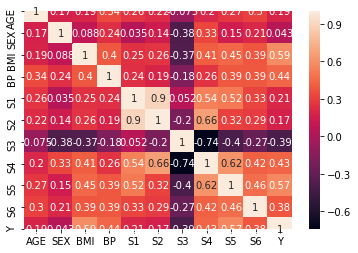

In [221]:
import seaborn as sns
sns.heatmap(data.corr(), annot=True)
plt.show()

S3 мешает

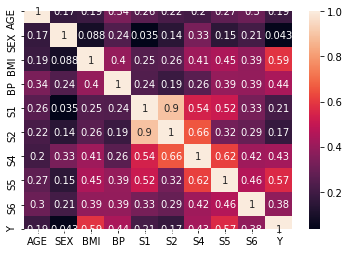

In [222]:
import seaborn as sns
data_wo_s3 = data.drop(columns=['S3']) 
sns.heatmap(data_wo_s3.corr(), annot=True)
plt.show()

ИМТ и S5 могут больше влиять на целевую переменную

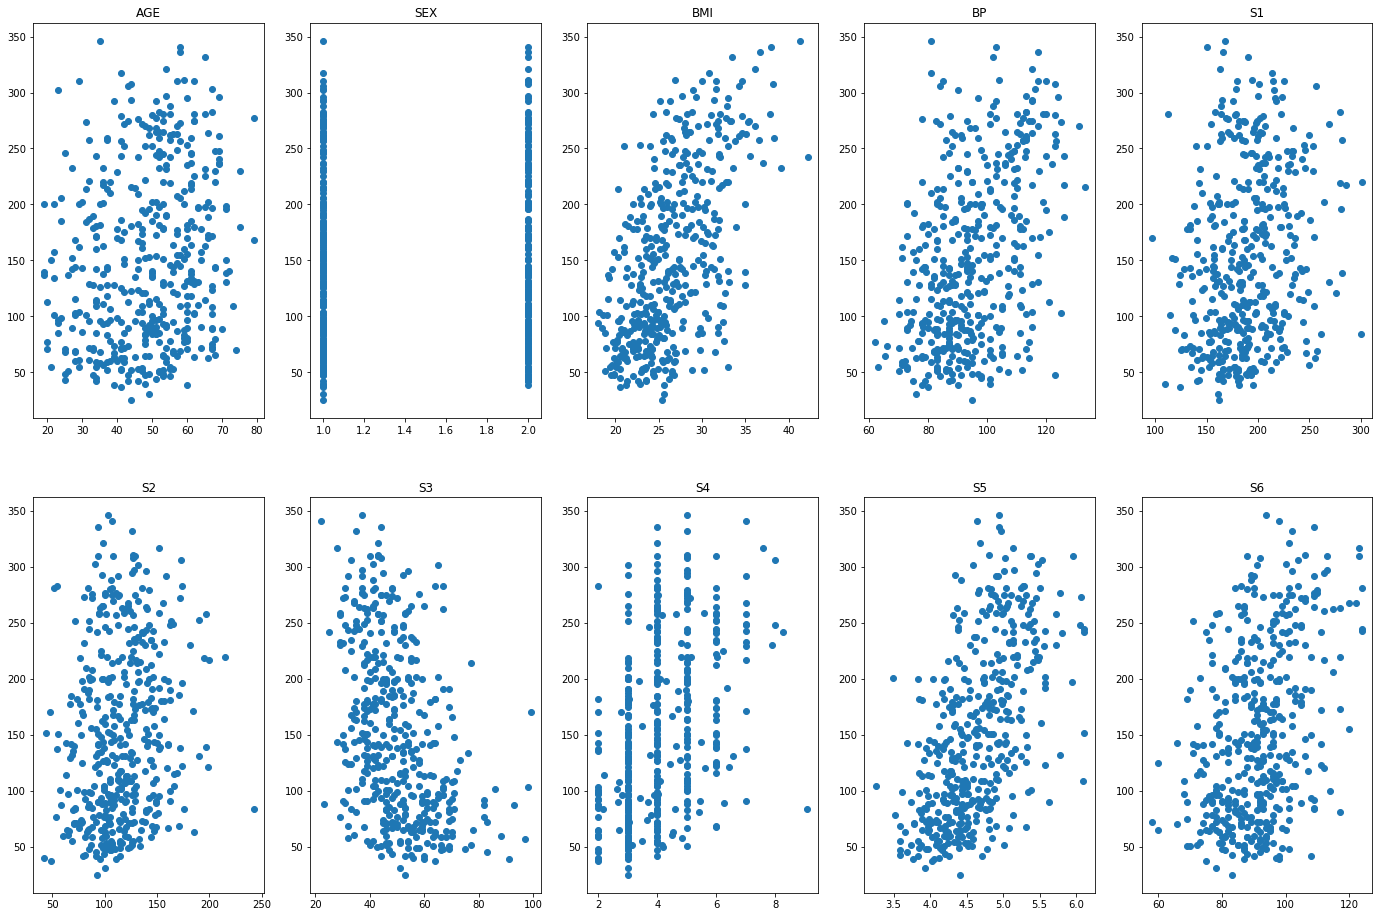

In [267]:
plt.subplots(figsize=(24,16))
columns = data.columns[:-1]
for num, val in enumerate(columns):
    plt.subplot(2, 5, num + 1)
    plt.scatter(data[val], data['Y'])
    plt.title(val)
plt.show()

Посмотрим на пол поточнее (наверное, 1 - это М, а 2 - Ж)

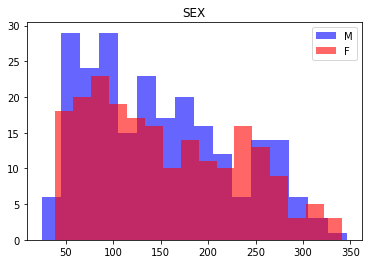

In [290]:
plt.hist(data[data['SEX'] == 1]['Y'], alpha=0.6, color='b', label='M', bins=16)
plt.hist(data[data['SEX'] == 2]['Y'], alpha=0.6, color='r', label='F', bins=16)
plt.legend()
plt.title('SEX')
plt.show()

Вроде пол никак не влияет

Попробуем обучить обычную линейную регрессию

In [270]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1488)

In [271]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_linreg = linreg.predict(X_test)
mean_squared_error(y_test, y_pred_linreg)

2935.9082797622955

In [286]:
errors = -cross_val_score(LinearRegression(), X, y, cv=5, scoring='neg_mean_squared_error')
print(np.mean(errors))

2993.081310469332


In [296]:
lambdas = np.arange(-0.1, 0.1, 0.005)
# print("Все лямбды:")
# print(lambdas)
lambda_errors = []
errors = []

for val in lambdas:
    lasso_reg = Lasso(alpha=val).fit(X, y)
    y_pred = lasso_reg.predict(X)
    lambda_errors.append((val, np.mean(-cross_val_score(lasso_reg, X, y, cv=5, scoring='neg_mean_squared_error'))))
    # print((val, np.mean(-cross_val_score(lasso_reg, X, y, cv=5, scoring='neg_mean_squared_error'))))
    errors.append(np.mean(-cross_val_score(lasso_reg, X, y, cv=5, scoring='neg_mean_squared_error')))

min_val, min_train_error = min(lambda_errors, key=lambda x: x[1])


print("\nОптимальная lambda:")
print("Lambda={:.2f}, результат={:.2f}".format(min_val, min_train_error))


Оптимальная lambda:
Lambda=-0.03, результат=2993.03


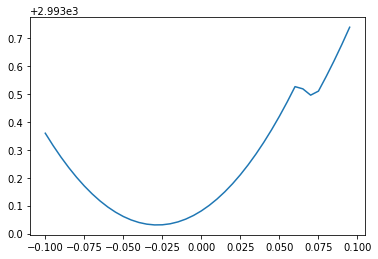

In [297]:
plt.plot(lambdas, errors)
plt.show()

In [293]:
opt_lasso = Lasso(alpha=-0.03)
lasso_model = opt_lasso.fit(X, y)
pd.DataFrame(zip(data.columns[:-1], lasso_model.coef_))

,0,1
0,AGE,-0.037003
1,SEX,-23.021878
2,BMI,5.595380
3,BP,1.117687
4,S1,-1.136543
5,S2,0.786352
6,S3,0.430724
7,S4,6.767537
8,S5,69.729372
9,S6,0.278539


In [311]:
lambdas = np.arange(-0.1, 0.3, 0.005)
# print("Все лямбды:")
# print(lambdas)
lambda_errors = []
errors = []

for val in lambdas:
    ridge_reg = Ridge(alpha=val).fit(X, y)
    y_pred = ridge_reg.predict(X)
    lambda_errors.append((val, np.mean(-cross_val_score(ridge_reg, X, y, cv=5, scoring='neg_mean_squared_error'))))
    # print((val, np.mean(-cross_val_score(ridge_reg, X, y, cv=5, scoring='neg_mean_squared_error'))))
    errors.append(np.mean(-cross_val_score(ridge_reg, X, y, cv=5, scoring='neg_mean_squared_error')))

min_val, min_train_error = min(lambda_errors, key=lambda x: x[1])


print("\nОптимальная lambda:")
print("Lambda={:.2f}, результат={:.2f}".format(min_val, min_train_error))


Оптимальная lambda:
Lambda=0.10, результат=2993.07


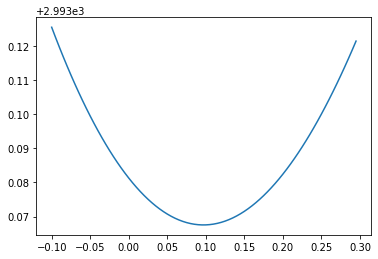

In [312]:
plt.plot(lambdas, errors)
plt.show()

In [314]:
opt_ridge = Ridge(alpha=0.1)
ridge_model = opt_ridge.fit(X, y)
pd.DataFrame(zip(data.columns[:-1], ridge_model.coef_))

,0,1
0,AGE,-0.035978
1,SEX,-22.834211
2,BMI,5.606966
3,BP,1.117056
4,S1,-1.071163
5,S2,0.729092
6,S3,0.351145
7,S4,6.503749
8,S5,67.912885
9,S6,0.280944


Попробуем убрать признаки с маленьким весом

In [315]:
X_opt = X.drop(['AGE', 'S2', 'S3', 'S6'], axis=1)
X_opt

,SEX,BMI,BP,S1,S4,S5
0,2,32.1,101.00,157,4.00,4.8598
1,1,21.6,87.00,183,3.00,3.8918
2,2,30.5,93.00,156,4.00,4.6728
3,1,25.3,84.00,198,5.00,4.8903
4,1,23.0,101.00,192,4.00,4.2905
...,...,...,...,...,...,...
437,2,28.2,112.00,185,4.00,4.9836
438,2,24.9,75.00,225,5.00,4.4427
439,2,24.9,99.67,162,3.77,4.1271
440,1,30.0,95.00,201,4.79,5.1299


In [316]:
errors = -cross_val_score(LinearRegression(), X_opt, y, cv=5, scoring='neg_mean_squared_error')
print(np.mean(errors))

2950.037176348973


MSE на обычной линейной регрессии стала меньше на 40

In [325]:
lambdas = np.arange(-0.1, 0.1, 0.001)
# print("Все лямбды:")
# print(lambdas)
lambda_errors = []
errors = []

for val in lambdas:
    lasso_reg_opt = Lasso(alpha=val).fit(X_opt, y)
    y_pred = lasso_reg_opt.predict(X_opt)
    lambda_errors.append((val, np.mean(-cross_val_score(lasso_reg_opt, X_opt, y, cv=5, scoring='neg_mean_squared_error'))))
    # print((val, np.mean(-cross_val_score(lasso_reg_opt, X_opt, y, cv=5, scoring='neg_mean_squared_error'))))
    errors.append(np.mean(-cross_val_score(lasso_reg_opt, X_opt, y, cv=5, scoring='neg_mean_squared_error')))

min_val, min_train_error = min(lambda_errors, key=lambda x: x[1])


print("\nОптимальная lambda:")
print("Lambda={:.2f}, результат={:.2f}".format(min_val, min_train_error))


Оптимальная lambda:
Lambda=-0.00, результат=2950.04


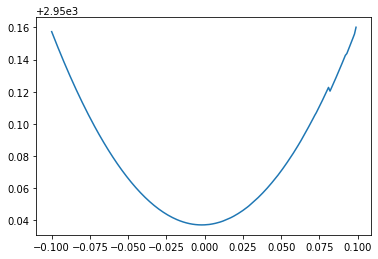

In [326]:
plt.plot(lambdas, errors)
plt.show()

С L1 лучше не стало

In [334]:
lambdas = np.arange(2, 3, 0.01)
# print("Все лямбды:")
# print(lambdas)
lambda_errors = []
errors = []

for val in lambdas:
    ridge_reg_opt = Ridge(alpha=val).fit(X_opt, y)
    y_pred = ridge_reg_opt.predict(X_opt)
    lambda_errors.append((val, np.mean(-cross_val_score(ridge_reg_opt, X_opt, y, cv=5, scoring='neg_mean_squared_error'))))
    # print((val, np.mean(-cross_val_score(ridge_reg_opt, X_opt, y, cv=5, scoring='neg_mean_squared_error'))))
    errors.append(np.mean(-cross_val_score(ridge_reg_opt, X_opt, y, cv=5, scoring='neg_mean_squared_error')))

min_val, min_train_error = min(lambda_errors, key=lambda x: x[1])


print("\nОптимальная lambda:")
print("Lambda={:.2f}, результат={:.2f}".format(min_val, min_train_error))


Оптимальная lambda:
Lambda=2.09, результат=2949.38


С помощью L2 чуть улучшилось

Попробуем отмасштабировать данные

In [335]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_opt)
X_scaled = scaler.transform(X_opt)

In [336]:
errors = -cross_val_score(LinearRegression(), X_scaled, y, cv=5, scoring='neg_mean_squared_error')
print(np.mean(errors))

2950.0371763489725


Не помогло...

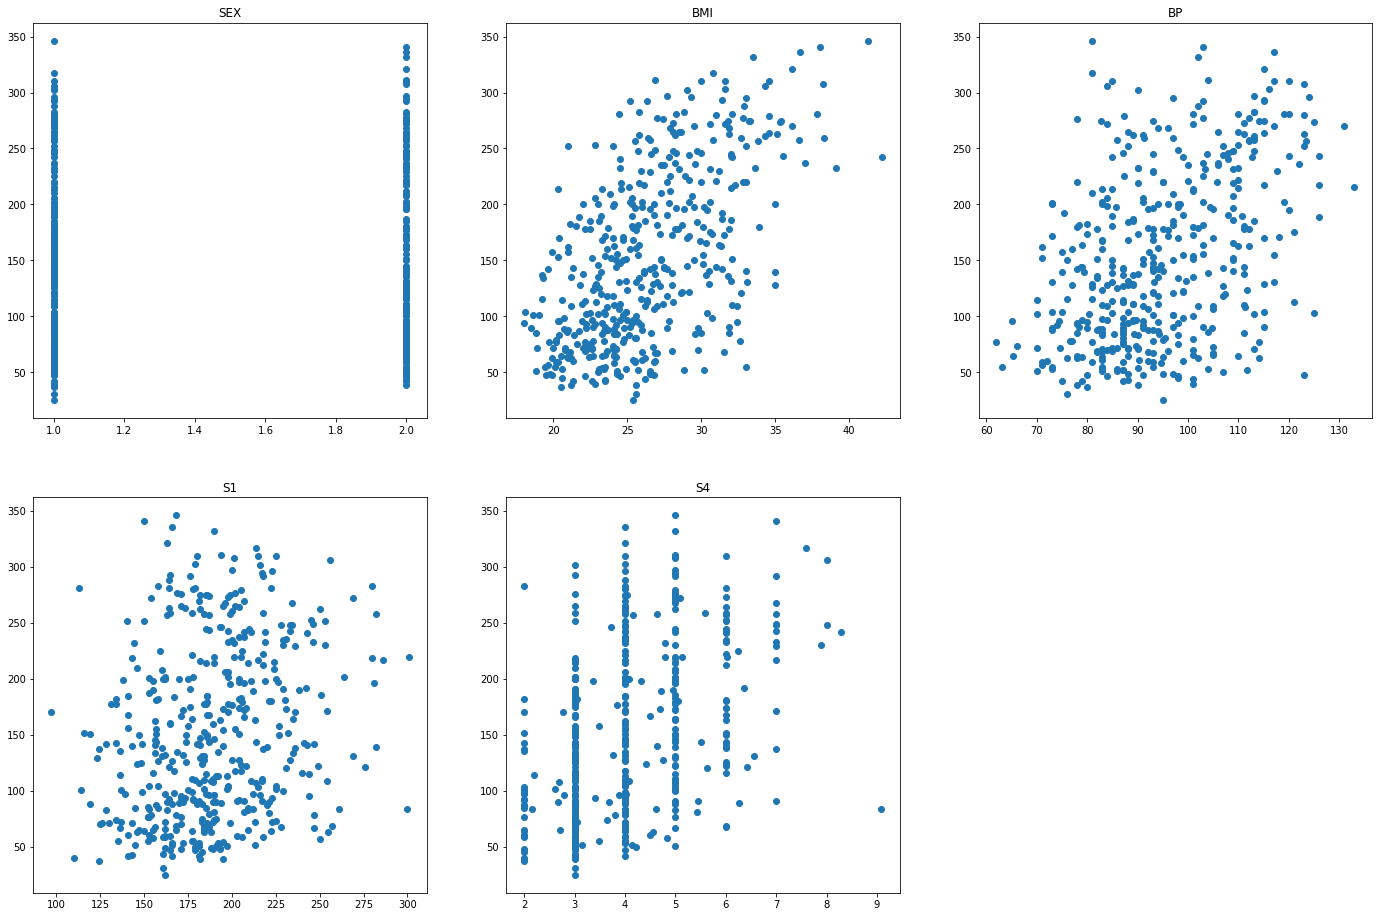

In [338]:
plt.subplots(figsize=(24,16))
columns = X_opt.columns[:-1]
for num, val in enumerate(columns):
    plt.subplot(2, 3, num + 1)
    plt.scatter(X_opt[val], data['Y'])
    plt.title(val)
plt.show()

Я, конечно, не врач, но, возможно, давление и вес могут быть связаны между собой и их можно перемножить...

In [339]:
X_opt['BMIBP'] = X_opt['BMI'] * X_opt['BP']
X_opt.head()

,SEX,BMI,BP,S1,S4,S5,BMIBP
0,2,32.1,101.0,157,4.0,4.8598,3242.1
1,1,21.6,87.0,183,3.0,3.8918,1879.2
2,2,30.5,93.0,156,4.0,4.6728,2836.5
3,1,25.3,84.0,198,5.0,4.8903,2125.2
4,1,23.0,101.0,192,4.0,4.2905,2323.0


In [340]:
errors = -cross_val_score(LinearRegression(), X_opt, y, cv=5, scoring='neg_mean_squared_error')
print(np.mean(errors))

2904.740673518244


Норм уменьшилось

На матрице корреляций S1 и S2 тоже связаны, тоже перемножить

In [345]:
X_opt['S1S4'] = X_opt['S1'] * X_opt['S4']

In [342]:
errors = -cross_val_score(LinearRegression(), X_opt, y, cv=5, scoring='neg_mean_squared_error')
print(np.mean(errors))

2926.9556039918707


Плохая идея

In [346]:
X_opt = X_opt.drop('S1S4', axis=1)
X_opt.head()

,SEX,BMI,BP,S1,S4,S5,BMIBP
0,2,32.1,101.0,157,4.0,4.8598,3242.1
1,1,21.6,87.0,183,3.0,3.8918,1879.2
2,2,30.5,93.0,156,4.0,4.6728,2836.5
3,1,25.3,84.0,198,5.0,4.8903,2125.2
4,1,23.0,101.0,192,4.0,4.2905,2323.0


In [349]:
lambdas = np.arange(-0.1, 0.1, 0.001)
# print("Все лямбды:")
# print(lambdas)
lambda_errors = []
errors = []

for val in lambdas:
    lasso_reg_opt = Lasso(alpha=val).fit(X_opt, y)
    y_pred = lasso_reg_opt.predict(X_opt)
    lambda_errors.append((val, np.mean(-cross_val_score(lasso_reg_opt, X_opt, y, cv=5, scoring='neg_mean_squared_error'))))
    # print((val, np.mean(-cross_val_score(lasso_reg_opt, X_opt, y, cv=5, scoring='neg_mean_squared_error'))))
    errors.append(np.mean(-cross_val_score(lasso_reg_opt, X_opt, y, cv=5, scoring='neg_mean_squared_error')))

min_val, min_train_error = min(lambda_errors, key=lambda x: x[1])


print("\nОптимальная lambda:")
print("Lambda={:.2f}, результат={:.2f}".format(min_val, min_train_error))


Оптимальная lambda:
Lambda=0.05, результат=2904.70


In [356]:
lambdas = np.arange(0.1, 10, 0.1)
# print("Все лямбды:")
# print(lambdas)
lambda_errors = []
errors = []

for val in lambdas:
    ridge_reg_opt = Ridge(alpha=val).fit(X_opt, y)
    y_pred = ridge_reg_opt.predict(X_opt)
    lambda_errors.append((val, np.mean(-cross_val_score(ridge_reg_opt, X_opt, y, cv=5, scoring='neg_mean_squared_error'))))
    # print((val, np.mean(-cross_val_score(ridge_reg_opt, X_opt, y, cv=5, scoring='neg_mean_squared_error'))))
    errors.append(np.mean(-cross_val_score(ridge_reg_opt, X_opt, y, cv=5, scoring='neg_mean_squared_error')))

min_val, min_train_error = min(lambda_errors, key=lambda x: x[1])


print("\nОптимальная lambda:")
print("Lambda={:.2f}, результат={:.2f}".format(min_val, min_train_error))


Оптимальная lambda:
Lambda=2.90, результат=2903.55


В итоге мы немного улучшили исходную модель, опираясь на получаемые результаты и житейский опыт... 

<img src="https://c.tenor.com/JZ1XdjdbHs8AAAAC/futurama-fry.gifhttps://c.tenor.com/3M8C_1GPijcAAAAC/master-gachi.gif">